# CST 4060 - Coursework 3
By Mykhailo Kaptyelov (M00915847)

The following cells contain implementation of various image processing techniques, some of which were suggested in the documents. I have ordered the implementation based on the procedural requirements of image segmentation in general terms.
Most of the implementations should be able to work with any .jpg picture named "me" that contain a human face and are 
located in the same directory where the code file is located.
We start off with the import block that contains most of the relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from tensorflow import keras
from tensorflow.keras import layers

The following block contains the gaussian filter implementation.
It begins with a class that handles the gneration a 2D gaussian kernel, then another class is defined that contains a filter, then proceeds with an initiation of a gaussian filter and it's application onto the image(that is read by PIL and
converted to grayscaale; this procedure(with variation of either grayscale or numpy array convertion) is repeated in almost every other implementation, so it is advised for it to be assumed).
It is finished by a display of an outcome using matplotlib.pyplot

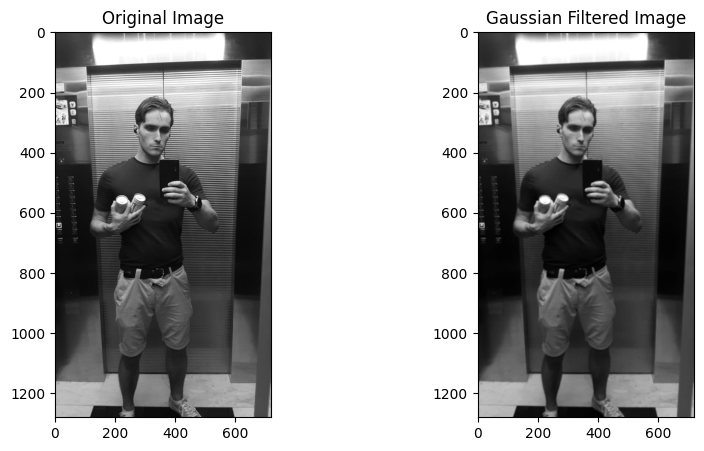

In [2]:
def gaussian_kernel(kernel_size, sigma):
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / (2 * np.pi * sigma**2)

def gaussian_filter(image, kernel_size=3, sigma=1):
    """Applies a 2D Gaussian filter to an image."""
    kernel = gaussian_kernel(kernel_size, sigma)
    output = np.zeros_like(image, dtype=float)
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_size, mode='edge')
    for i in range(pad_size, padded_image.shape[0]-pad_size):
        for j in range(pad_size, padded_image.shape[1]-pad_size):
            patch = padded_image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
            output[i-pad_size, j-pad_size] = np.sum(patch * kernel)
    return output.astype(np.uint8)


img = Image.open("me.jpg").convert("L")
img = np.array(img)

filtered_img = gaussian_filter(img, kernel_size=5, sigma=2)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(filtered_img, cmap="gray")
ax[1].set_title("Gaussian Filtered Image")
plt.show()


The following implementation of a color histogram begins with reading the image, and converting it into a numpy array. 
Then a gray histogram is computed, then a color one, and then they are plotted and displayed.

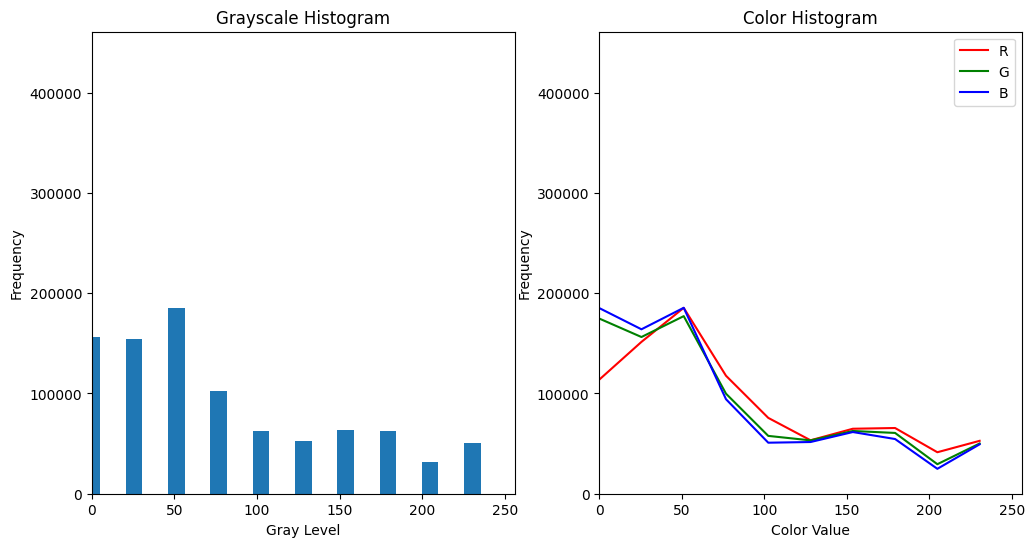

In [3]:
with Image.open("me.jpg") as img:
    gray_pixels = np.array(img.convert("L"))
    color_pixels = np.array(img)

gray_histogram, gray_bins = np.histogram(gray_pixels, bins=10, range=(0, 256))

color_histogram, color_bins = [], []
for i in range(3):
    hist, bins = np.histogram(color_pixels[:,:,i], bins=10, range=(0, 256))
    color_histogram.append(hist)
    color_bins.append(bins)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))


axs[0].bar(gray_bins[:-1], gray_histogram, width=10)
axs[0].set_xlim(0, 256)
axs[0].set_ylim(0, gray_pixels.shape[0]*gray_pixels.shape[1]*0.5)
axs[0].set_xlabel("Gray Level")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Grayscale Histogram")


colors = ['r', 'g', 'b']
for i in range(3):
    axs[1].plot(color_bins[i][:-1], color_histogram[i], color=colors[i], label=colors[i].upper())

axs[1].set_xlim(0, 256)
axs[1].set_ylim(0, color_pixels.shape[0]*color_pixels.shape[1]*0.5)
axs[1].set_xlabel("Color Value")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Color Histogram")
axs[1].legend()

plt.show()

This implementation of RGB color distribution begins by loading the image and converting it into an array, then the color distribution(by pixel) 
is computed, then the color distribution scatterplot is created, and displayed.

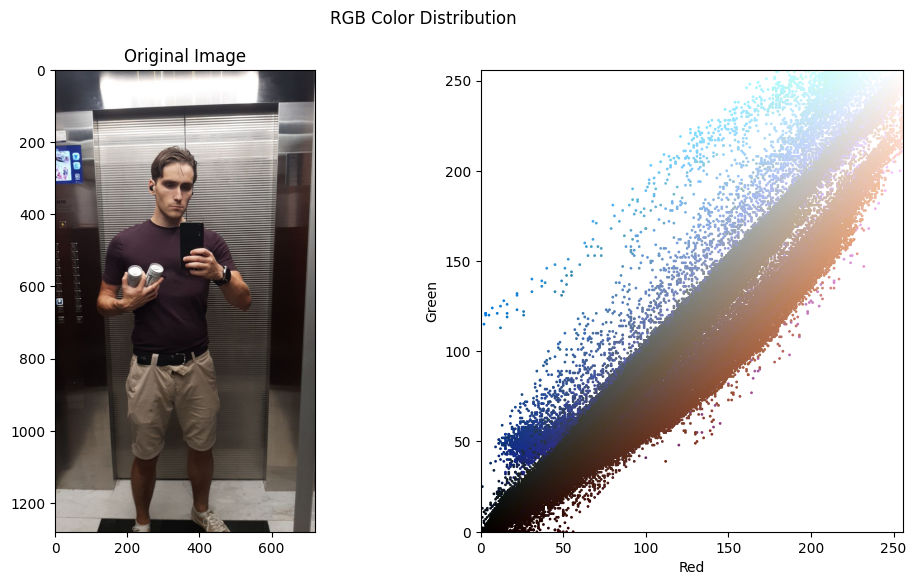

In [4]:
image = Image.open("me.jpg")
pixels = np.array(image)

red = pixels[:,:,0].ravel()
green = pixels[:,:,1].ravel()
blue = pixels[:,:,2].ravel()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("RGB Color Distribution")

axs[0].imshow(image)
axs[0].set_title("Original Image")

axs[1].scatter(red, green, c=np.array([red, green, blue]).T / 255.0, s=1)
axs[1].set_xlabel("Red")
axs[1].set_ylabel("Green")
axs[1].set_xlim(0, 256)
axs[1].set_ylim(0, 256)
plt.show()

This block contains a multi-color segmentation, begins by loading and converting the image, then immediately followed after by color range definition in the format of [min_hue, max_hue, min_saturation, max_saturation, min_value, max_value], and then is followed by, I suppose, the most elaborate loop I've ever produced yet - it checks through each pixel in the image and check if it falls within the color range for each color, and then the results are plotted.


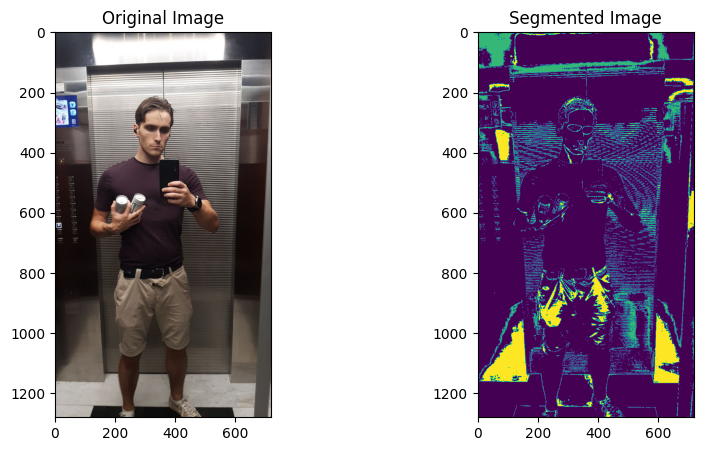

In [5]:
image = Image.open("me.jpg")
pixels = np.array(image)

red_range = [0, 10, 50, 255, 50, 255]
green_range = [45, 70, 50, 255, 50, 255]
blue_range = [100, 125, 50, 255, 50, 255]

labels = np.zeros((pixels.shape[0], pixels.shape[1]), dtype=np.uint8)
for i in range(pixels.shape[0]):
    for j in range(pixels.shape[1]):
        pixel = pixels[i, j]
        if (pixel[0] >= red_range[0] and pixel[0] <= red_range[1] and
            pixel[1] >= red_range[2] and pixel[1] <= red_range[3] and
            pixel[2] >= red_range[4] and pixel[2] <= red_range[5]):
            labels[i, j] = 1
        elif (pixel[0] >= green_range[0] and pixel[0] <= green_range[1] and
              pixel[1] >= green_range[2] and pixel[1] <= green_range[3] and
              pixel[2] >= green_range[4] and pixel[2] <= green_range[5]):
            labels[i, j] = 2
        elif (pixel[0] >= blue_range[0] and pixel[0] <= blue_range[1] and
              pixel[1] >= blue_range[2] and pixel[1] <= blue_range[3] and
              pixel[2] >= blue_range[4] and pixel[2] <= blue_range[5]):
            labels[i, j] = 3

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(labels)
axs[1].set_title("Segmented Image")
plt.show()

This block, containing a Mean Shift segmentation, begins by loading and converting the image, then the image data is reshaped into a 2d array of RGB values,
then the bandwidth parameter is estimated, then segmentation using the Scikit-Learn library is performed, 
then the RGB values are assebled into the shape of the original image, and then the results are displayed.

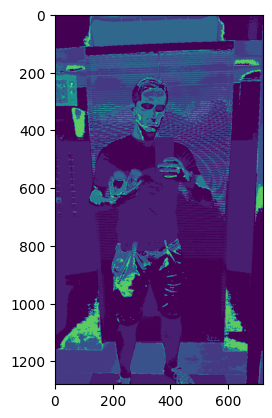

In [6]:
image = Image.open("me.jpg")
pixels = np.array(image)

h, w, d = pixels.shape
image_2d = pixels.reshape((h * w, d))

bandwidth = estimate_bandwidth(image_2d, quantile=0.1, n_samples=100)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(image_2d)
labels = ms.labels_

segmented_image = labels.reshape((h, w))

plt.imshow(segmented_image)
plt.show()

This implementation of local maxima of gradiednt begins by loading and converting the image, followed by computing the gradient magnitude, followed by finding the local maxima of gradient, then the index of center pixel is set, 
and finally a plot of the result.

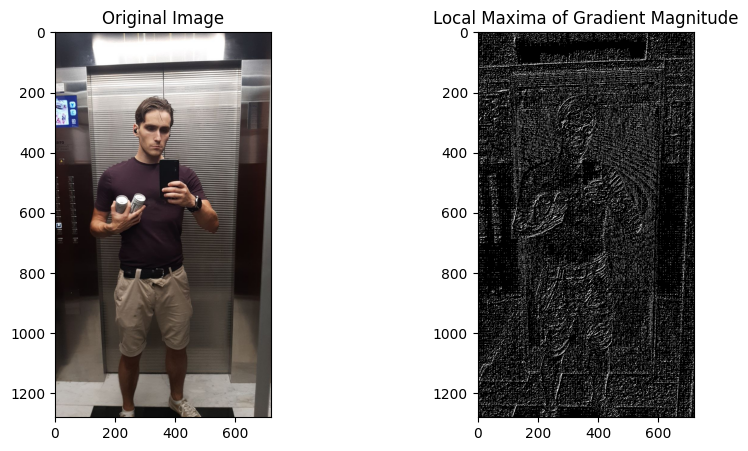

In [7]:
image = plt.imread('me.jpg')

gray_image = np.mean(image, axis=2)

gx, gy = np.gradient(gray_image.astype(np.float64))
gradient_magnitude = np.sqrt(gx ** 2 + gy ** 2)

local_maxima = np.zeros_like(gradient_magnitude)
for i in range(1, gradient_magnitude.shape[0]-1):
    for j in range(1, gradient_magnitude.shape[1]-1):
        neighbors = gradient_magnitude[i-1:i+2, j-1:j+2].flatten()
        if np.argmax(neighbors) == 8:
            local_maxima[i, j] = 2

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(local_maxima, cmap='gray')
ax[1].set_title('Local Maxima of Gradient Magnitude')
plt.show()

The following block contains the implementation of Prewitt edge detection method. it begins by loading and converting the image, then followed by definition of Prewitt kernels, convolving them with the image, and computing the gradient magnitude.
Then the results are displayed.

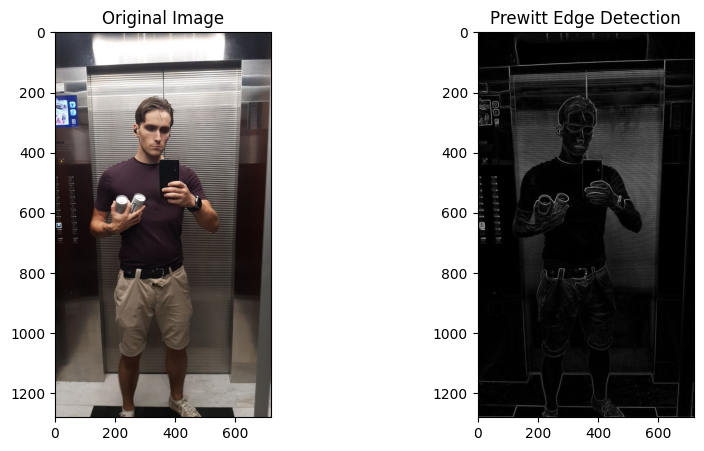

In [8]:
image = plt.imread('me.jpg')
gray_image = np.mean(image, axis=2)

kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

grad_x = np.abs(convolve2d(gray_image, kernel_x, mode='same'))
grad_y = np.abs(convolve2d(gray_image, kernel_y, mode='same'))

grad_mag = np.sqrt(grad_x**2 + grad_y**2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(grad_mag, cmap='gray')
ax[1].set_title('Prewitt Edge Detection')
plt.show()

The following block contains the implementation of Robert's edge detection method. it begins by loading and converting the image, then followed by application of gaussian smoothing, and application of Robert's edge detection algorithm afterwards.
Then the results are displayed.

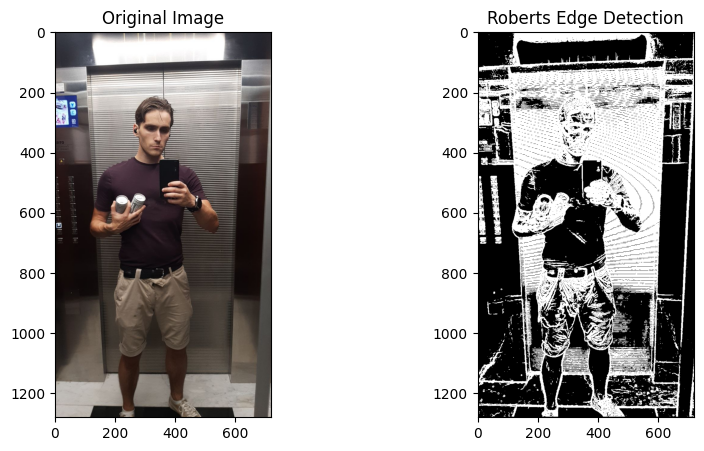

In [9]:
img = plt.imread('me.jpg')

img_gray = np.mean(img, axis=2)

sigma = 1
img_smooth = ndimage.gaussian_filter(img_gray, sigma)

threshold = 2.8
grad_x = np.zeros_like(img_smooth)
grad_y = np.zeros_like(img_smooth)
grad_x[:-1, :-1] = img_smooth[1:, 1:] - img_smooth[:-1, :-1]
grad_y[:-1, :-1] = img_smooth[:-1, 1:] - img_smooth[1:, :-1]
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
edges = np.zeros_like(grad_mag)
edges[grad_mag > threshold] = 1

# Display the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Roberts Edge Detection')
plt.show()

This block contains the Sobel edge detection method implementation, and starts with definition of a class, within which the obbject "inmage" is converted to grayscale, then the gaussian smoothing is being applied, followed by defining sobel filters, then followed by computing gradients in x and y directions, gradient magnitude, and application of threshold in order to detect edges. This essentially produces a 'template' by which the loaded image is being processed.
Then the results are displayed.

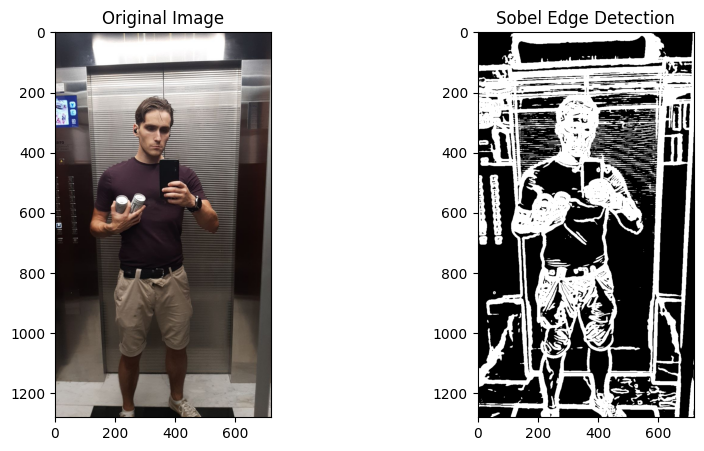

In [10]:
def sobel_edge_detection(image, threshold, sigma):

    gray_image = np.mean(image, axis=2)
    
    smoothed_image = ndimage.gaussian_filter(gray_image, sigma=sigma)
    
    sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    gx = ndimage.convolve(smoothed_image, sx)
    gy = ndimage.convolve(smoothed_image, sy)
    
    gradient_magnitude = np.sqrt(gx**2 + gy**2)
    
    edges = np.zeros_like(gradient_magnitude)
    edges[gradient_magnitude > threshold] = 1
    
    return edges

image = plt.imread('me.jpg')

edges = sobel_edge_detection(image, threshold=7.0, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Sobel Edge Detection')
plt.show()

This is an implementation of CNN segmentation model with five convolution layers. It begins by loading and converting the image, followed by normalization of pixel values. 
Then the input shape of the model is defined, then the model architecture is defined, then it is compiled based on those, and then channel dimension is added to the image, and it is reshaped to match the input shape of the model.
Then the model is trained, and finally the image is passed through it.
The results are displayed below.
For better accuracy, I opted for 36 iterations.

Epoch 1/36
1/1 [==============================] - 5s 5s/step - loss: 0.6931
Epoch 2/36
1/1 [==============================] - 4s 4s/step - loss: 0.6908
Epoch 3/36
1/1 [==============================] - 4s 4s/step - loss: 0.6855
Epoch 4/36
1/1 [==============================] - 4s 4s/step - loss: 0.6792
Epoch 5/36
1/1 [==============================] - 4s 4s/step - loss: 0.6778
Epoch 6/36
1/1 [==============================] - 4s 4s/step - loss: 0.6624
Epoch 7/36
1/1 [==============================] - 4s 4s/step - loss: 0.6655
Epoch 8/36
1/1 [==============================] - 4s 4s/step - loss: 0.6517
Epoch 9/36
1/1 [==============================] - 4s 4s/step - loss: 0.6457
Epoch 10/36
1/1 [==============================] - 4s 4s/step - loss: 0.6226
Epoch 11/36
1/1 [==============================] - 4s 4s/step - loss: 0.6082
Epoch 12/36
1/1 [==============================] - 4s 4s/step - loss: 0.5670
Epoch 13/36
1/1 [==============================] - 4s 4s/step - loss: 0.5603
Epoch 14

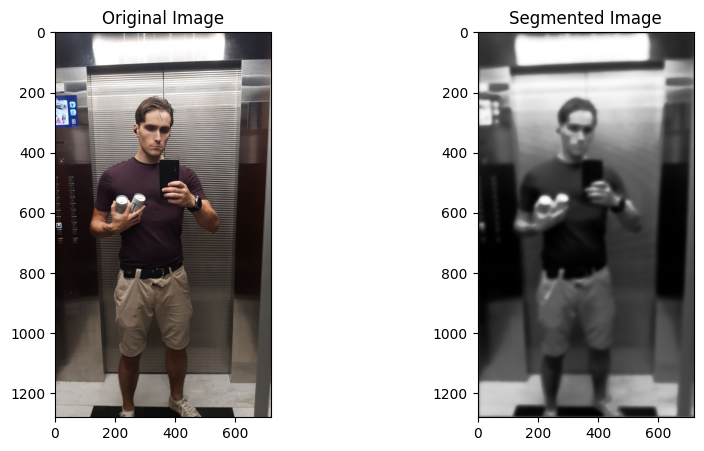

In [11]:
image = plt.imread('me.jpg')

gray_image = np.mean(image, axis=2) / 255.0

input_shape = gray_image.shape + (1,)

model = keras.Sequential(
    [
        layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=input_shape),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.Conv2D(1, 1, activation="sigmoid", padding="same"),
    ]
)

model.compile(optimizer="adam", loss="binary_crossentropy")

input_image = np.expand_dims(gray_image, axis=-1)
input_image = np.reshape(input_image, (1,) + input_shape)

model.fit(input_image, input_image, epochs=36)

predicted_image = model.predict(input_image)[0, :, :, 0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(predicted_image, cmap='gray')
ax[1].set_title('Segmented Image')
plt.show()

The following block contains a K-Means clustering implementation. It starts with reading the imnage, and reshaping it into a 2D array of RGB values. Then K-Means clustering with 3 clusters is applied, followed by the transformation of the lables array back into the shape of the image, finished by displaying the result.

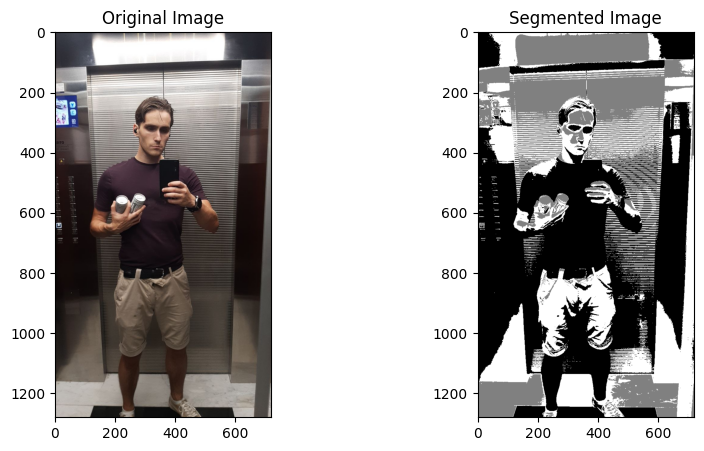

In [12]:
img = plt.imread('me.jpg')

X = img.reshape(-1, 3)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_

seg_img = labels.reshape(img.shape[:2])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(seg_img, cmap='gray')
ax[1].set_title('Segmented Image')
plt.show()

From this point, the implementations contain supporting libraries, like cv2, which were heavily discouraged.

This implementation of MTCNN face detection required additional import. It starts by loading the image, followed by initialization of the MTCNN detector, then followed by detection of a face, and then plotting of the result.
By default it contains only 10 iterations, unless specified.

1/1 [==============================] - 0s 98ms/step


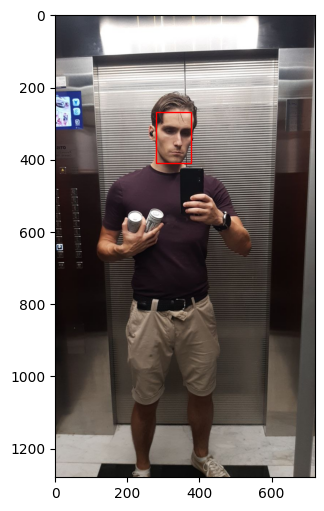

In [14]:
from mtcnn import MTCNN

image = Image.open("me.jpg")
pixels = np.array(image)

detector = MTCNN()

faces = detector.detect_faces(pixels)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(pixels)
for face in faces:
    x, y, width, height = face['box']
    rect = plt.Rectangle((x, y), width, height, fill=False, color='red')
    ax.add_patch(rect)
plt.show()

This is a small bonus program that detects edges from live camera using cv2 filters. 
Press 'q' to terminate the loop.

In [16]:
#This is a bonus that detects edges from live camera. Press 'q' to terminate the loop
import cv2
cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 30, 100)
    cv2.imshow("edges", edges)
    cv2.imshow("gray", gray)
    if cv2.waitKey(1) == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

Before the conclusion, I wanted to mention why I have decided AGAINST using SVM. SVM constitutes a classification tool, that is ill fitted for image segmentation, and requires external dataset in order to train; it also requires significant computational power, and therefore time. While it is still possible to use it for such purposes, I find it rather unreasonable.
And with that out of the way, I will conclude this document. Thank you for your time and attention.